# Semi-conductor dataset
The semi-conductor dataset is a large dataset composed of nearly 600 features for testing semi-conductors. For detailed information consult the README.md

#### Objective and tasks
Our objective is to use the features to predict whether a semi-conductor has passed a validation test. In order to do so we need:
1. To reduces the number of features in the dataset either by dimension reduction techniques or by feature selection or by both. 
2. Predict whether a conductor passed or failed the test
3. Validate our predictions. 
4. Implement a ready to use .py file with the chosen techniques      

#### Plan
"I have a plan, its a crazy plan, but a plan non the less" Angus from the Spy-dog animation

Our predictions will be effected essentially by to main decisions: 1. How to reduce the dataset and select the features and 2. What model to use. So our plan might be drawn like this:
1. Clean the data
2. Apply several dimension reduction or feature selection techniques: 
    - PCA and used the components as features
    - Select the best features via correlations metrics
    - Select features via the Boruta algorithm
    - Singular Value Decomposition
3. Use the end features or components to predict via several models:
    - Logistic regression
    - Random forest
    - Gradient boosting machine
4. From step 4 we will have 12 combinations of reduction techniques and models, we may chose the top 3 or 4 of them and fine tune the model via hyperparameter tunning.
5. Validate the model

Note that there are many dimension reduction techniques and model types out there so my choices here are to some extent arbitrary derived only from my previous experience and current knowledge. So by all means any suggestions to improve this are welcomed.   


### Import libraries and data

In [608]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [609]:
df = pd.read_csv("uci-secom.csv")

In [610]:
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


### Data cleaning

Let us first relabel the target column so that the test fail = 0 and the pass = 1 

In [611]:
df['Pass/Fail'] = df['Pass/Fail'].replace(to_replace=[-1,1], value=[1,0])

##### NaN handling
We were warned in the documentation that there are a lot of NaNs in this dataset, let us have a look 

In [612]:
np.count_nonzero(df.isna().sum())

538

Nearly all the columns have some missing values. 

In [613]:
df.isna().sum().sort_values(ascending=False).head(20)

158    1429
292    1429
293    1429
157    1429
85     1341
492    1341
220    1341
358    1341
517    1018
245    1018
246    1018
518    1018
382    1018
516    1018
109    1018
111    1018
244    1018
110    1018
384    1018
383    1018
dtype: int64

We see that there are columns with more NaNs than values, which won't help us in the prediction task, so let us remove all columns where there are more then 40% missing values 

In [614]:
def percentna(dataframe, threshold):
    '''Get a list of column names where the number of NaNs is above a % threshold'''
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold]
    return columns.tolist()

In [615]:
na_columns = percentna(df, 0.4)

In [616]:
len(na_columns)

52

There are 52 features where the number of NaNs is above teh threshold, which is less then 10% of all the features, so let us remove these. Note that I will keep the original data set for later testing.

In [617]:
df2 = df.drop(na_columns, axis = 1)

In [618]:
df.columns

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '581', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=592)

There is the timestamp column, which does not really give us any value in terms of prediction, so let us drop it as well.

In [619]:
df = df.drop('Time', axis=1)
df2 = df2.drop('Time', axis=1)

##### Outliers
Before imputing the missing values in the rest of the columns it is a good idea to check for outliers, because when imputing we rely on the existing data points and an outlier can potentially compromise the imputation. So let us apply the common rule of thumb which is that a data point, which is 3*SD away from the mean is considered an outlier.  

The awkward moment here is that there are to much features for us to manually visualize them or checkout their descriptive statistics one by one. Let us start by exploring the number of outliers for each feature.  

In [620]:
def outlier_explorer(df, columns, n_std):
    '''Explore the number of outliers for each column'''
    outlier_df = pd.DataFrame()
    outlier_count = []
    nan_count = [] 

    for column in columns:
        mean = df[column].mean()
        sd = df[column].std()
        n_outleirs = sum((df2[column] > mean+(3*sd)))
        n_nan = df[column].isna().sum()
        outlier_count.append(n_outleirs)
        nan_count.append(n_nan)

    outlier_df['Name'] = columns
    outlier_df['Outliers'] = outlier_count
    outlier_df['NaNs'] = nan_count

    return outlier_df

In [621]:
x = outlier_explorer(df2, df2.columns, 3)
x.sort_values(by = 'Outliers', ascending=False)


,Name,Outliers,NaNs
528,576,70,0
526,574,68,0
38,38,64,1
529,577,62,0
525,573,60,0
...,...,...,...
421,444,0,1
184,193,0,4
183,192,0,4
424,447,0,1


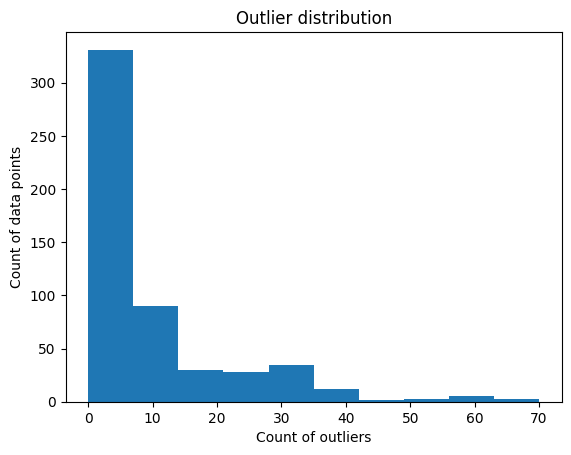

In [622]:
plt.hist(x['Outliers'])
plt.title('Outlier distribution')
plt.xlabel('Count of outliers')
plt.ylabel('Count of data points')
plt.show()

In [623]:
len(x[x['Outliers'] > 40])

13

Most have 0 to 5 outliers, while a very small portion of the features (13 to be exact) have over 40 outliers. These are suspicious and show an obvious visual separation from the other features. Let us look at them more closely.    

In [624]:
z = x[x['Outliers'] > 40]
df2[(z['Name'])].describe()

,38,139,160,274,295,558,572,573,574,575,576,577,589
count,1566.000000,1553.000000,1565.000000,1553.000000,1565.000000,1566.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1566.000000
mean,86.836577,416.766964,555.346326,136.292426,252.999118,0.995009,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,99.670066
std,0.446756,263.300614,574.808588,85.607784,283.530702,0.083860,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,93.891919
min,84.732700,0.000000,0.000000,0.000000,0.000000,0.891900,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,0.000000
25%,86.578300,243.786000,295.000000,81.215600,130.220300,0.955200,7.500000,0.242250,2.567850,0.075100,1.408450,11.501550,44.368600
50%,86.820700,339.561000,438.000000,110.601400,195.825600,0.972700,8.650000,0.293400,2.975800,0.089500,1.624500,13.817900,71.900500
75%,87.002400,502.205900,625.000000,162.038200,273.952600,1.000800,10.130000,0.366900,3.492500,0.112150,1.902000,17.080900,114.749700
max,88.418800,1770.690900,4170.000000,659.169600,2005.874400,1.512100,454.560000,2.196700,170.020400,0.550200,90.423500,96.960100,737.304800


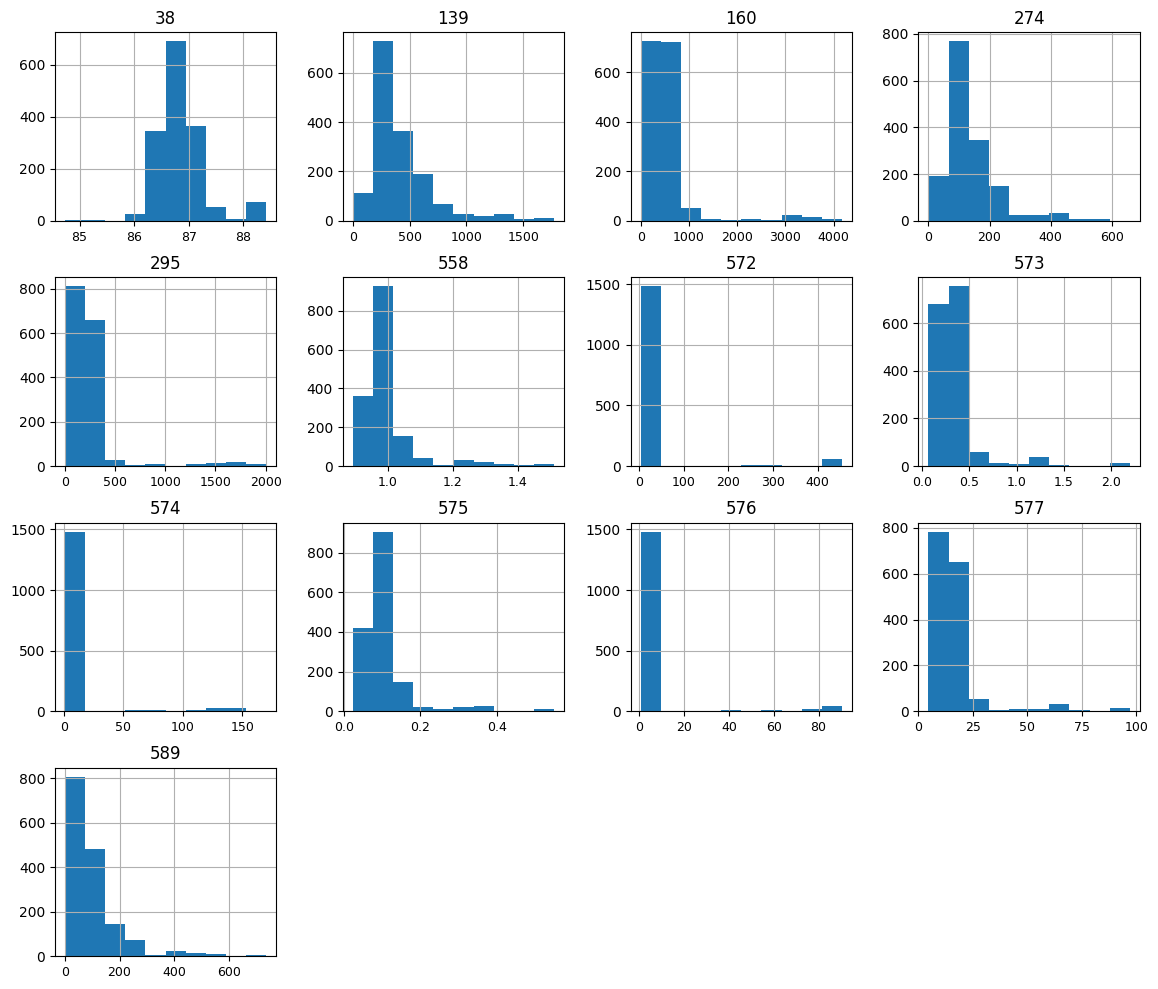

In [625]:
histograms = df2[(z['Name'])].hist(figsize=(14,12), xlabelsize = 9)

Looking at these plots visually "I do not like" `160`, `295`, `572`, `573`, `574`, `575`, `576`, `577`, in fact 6 of these fall in to sequence and it is quite possible that they are connected. In a dataset with fewer features I would not remove such only because of their distribution graph, but here we have no context for each feature, we do not know what feature `160` is or how is it measured. Since here our objective is to reduce the dimensionality of the dataset first we may comfortably remove some of these.   

In [626]:
df2 = df2.drop(['160', '295', '572', '573', '574', '575', '576', '577'], axis=1)

I also want to check the relation between number of outliers and number of NaNs (which we still have not imputed). There might be a feature with both a high number of NaNs and outliers. In fact let us sum up the two columns to make a `Bad data point` column

In [627]:
x['Bad data point'] = x['NaNs'] + x['Outliers']
n = x.sort_values(by = 'Bad data point', ascending=False)
n.head(20)

,Name,Outliers,NaNs,Bad data point
472,496,39,51,90
343,362,25,51,76
214,224,25,51,76
528,576,70,0,70
215,225,18,51,69
526,574,68,0,68
473,497,16,51,67
344,363,15,51,66
38,38,64,1,65
260,274,51,14,65


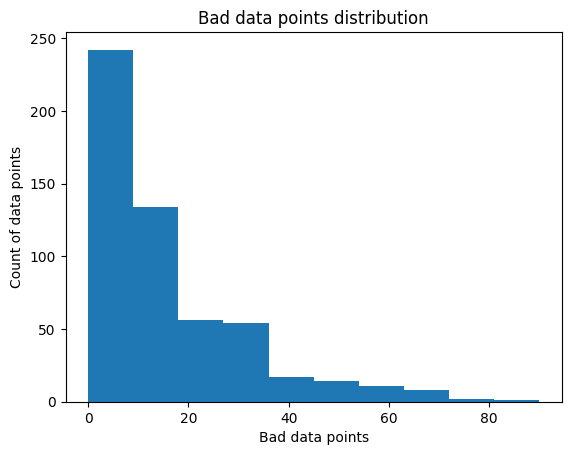

In [628]:
plt.hist(x['Bad data point'])
plt.title('Bad data points distribution')
plt.xlabel('Bad data points')
plt.ylabel('Count of data points')
plt.show()

In [629]:
len(df2)

1567

Sixteen features have >= 60 Bad data points. We already removed 5 of these features in the last step. Currently our dataset has 1567 observations so for such features about 3.8% of the data is either Nan or an outlier. That is ok as a whole, just out of curiosity let us explore there 11 features further.  

In [636]:
g = x[~x['Name'].isin(['160', '295', '572', '573', '574', '575', '576', '577'])]
h = g[g['Bad data point'] >= 60]
df2[(h['Name'])].describe()

,38,90,139,224,225,274,362,363,483,496,497
count,1566.000000,1516.000000,1553.000000,1516.000000,1516.000000,1553.000000,1516.000000,1516.000000,1543.000000,1516.000000,1516.000000
mean,86.836577,8827.536865,416.766964,0.059370,1041.056588,136.292426,0.018383,333.319601,206.564196,29.865896,11.821030
std,0.446756,396.313662,263.300614,0.071211,433.170076,85.607784,0.021644,138.801928,192.864413,24.621586,4.956647
min,84.732700,7397.310000,0.000000,0.009300,168.799800,0.000000,0.002800,60.988200,0.000000,4.813500,1.949600
25%,86.578300,8564.689975,243.786000,0.029775,718.725350,81.215600,0.009500,228.682525,81.316150,16.342300,8.150350
50%,86.820700,8825.435100,339.561000,0.039800,967.299800,110.601400,0.012500,309.831650,148.317500,22.039100,10.906550
75%,87.002400,9065.432400,502.205900,0.061300,1261.299800,162.038200,0.018600,412.329775,262.865250,32.438475,14.469050
max,88.418800,10746.600000,1770.690900,1.436100,3601.299800,659.169600,0.416300,1072.203100,989.473700,219.643600,40.281800


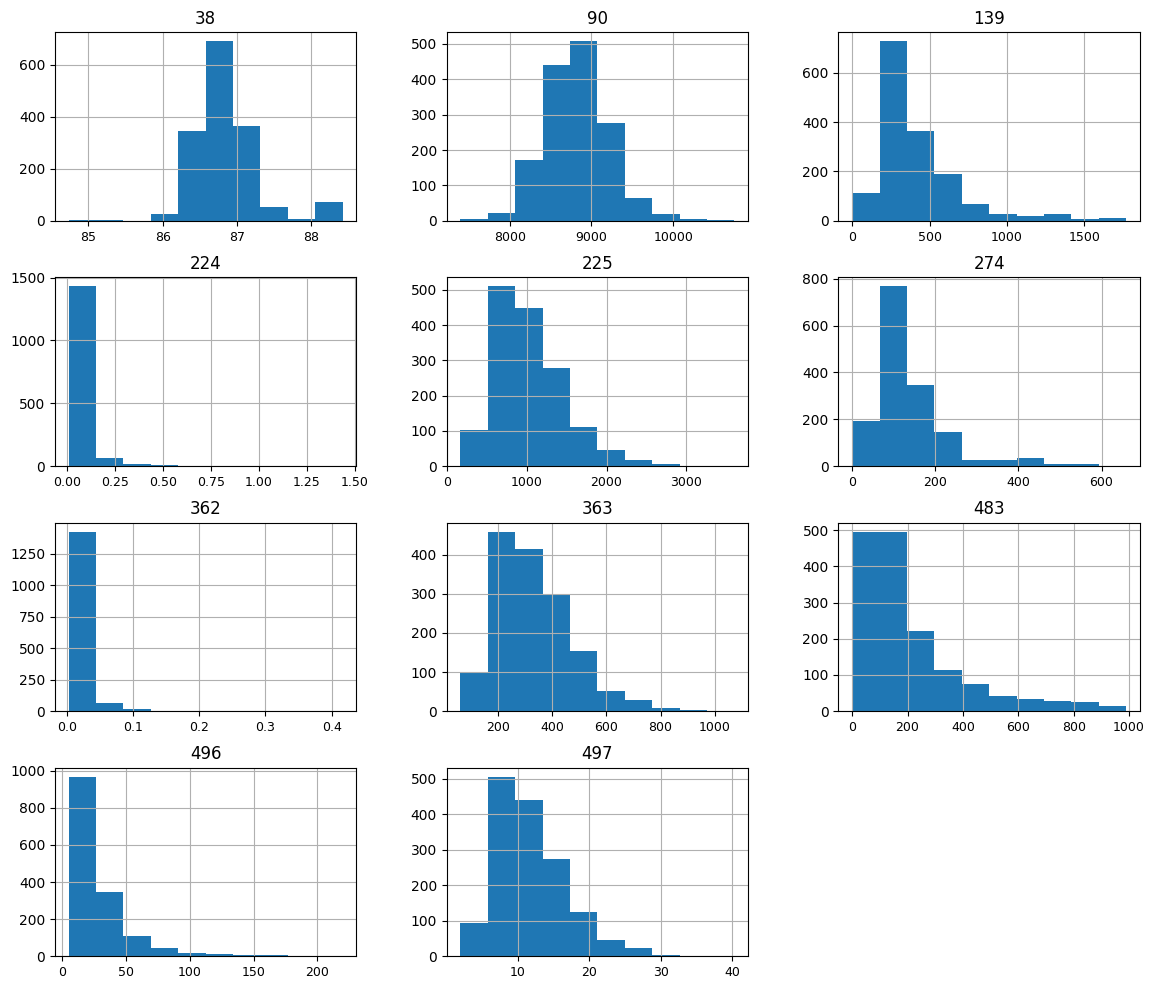

In [637]:
histograms = df2[(h['Name'])].hist(figsize=(14,12), xlabelsize = 9)

I believe that the imputation of NaNs and Outliers should suffice for these 11, no need to remove the whole features

In [542]:
def outlier_remover(df, columns, n_std):
    '''Removes outliers for all columns in a dataset, which keeping NaN values'''
    for column in columns:
        mean = df[column].mean()
        sd = df[column].std()
        df = df[((df[column] <= mean+(n_std*sd))) | df[column].isna()]        
    return df

In [543]:
len(df2)

1567

In [544]:
df2 = outlier_remover(df2, df2.columns,3) 

In [545]:
len(df2)

91